In [1]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import math

#import data
from biom import load_table
from gneiss.util import match
#deicode
from deicode.optspace import OptSpace
from deicode.utils import get_enriched_labels,get_mean_abundance,get_lowest_level
from deicode.preprocessing import rclr,inverse_rclr
#transforms 
from skbio.stats.composition import clr,ilr,centralize, ilr_inv,closure
#PCoA
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
#else
#regression
from gneiss.regression import ols
from gneiss.composition import ilr_transform
from gneiss.cluster import correlation_linkage

%matplotlib inline
# make the notebook readable
from IPython.core.display import HTML
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")



Developing infant gut microbiome (case study)

Succession of microbial consortia in the developing infant gut microbiome (Qiita Project - ID 101). 

"This study revealed that seemingly chaotic shifts in the microbiome could be attributed to life events."

Ruth Ley (Cornell University) [Data and Source](https://qiita.ucsd.edu/study/description/101)

First we import the .biom OTU table and tab delimited mapping file (qiime style).

In [35]:
from biom import load_table
from gneiss.util import match

# import observation data
in_biom='data/infant/ley.biom' #import biom file
table = load_table(in_biom)
sample_filter = lambda val, id_, md: sum(val) > 500
table = table.filter(sample_filter, axis='sample')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)
otutabledf=otutabledf.drop(['101.Mother'])
# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

mappingdf=pd.read_table('data/infant/mapping.txt',index_col=0)
mappingdf.replace({'solidfood': {'PRE': 'Pre Solid Food', 'POST': 'Post Solid Food'}},inplace=True)

#match the tables
otutabledf,mappingdf=match(otutabledf,mappingdf)

#sort by age
mappingdf.sort_values('age',inplace=True)
otutabledf=otutabledf.reindex(mappingdf.index)


Now we can extract OTUs (features) that separate the gut across the introduction of solid food.

We want to see if solid food is an important category. We would also like to find out what pattern of OTUs best explain possible variation between life stages. In this case we use a rank of 2 because solid food has two possible classes; PRE or POST.

In [36]:

table_norm=rclr().fit_transform(otutabledf.copy())
opt=OptSpace(rank=2,iteration=5,tol=1e-5).fit(table_norm)
sample_loading=pd.DataFrame(opt.sample_weights,index=otutabledf.index)
feature_loading=pd.DataFrame(opt.feature_weights,index=otutabledf.columns)

raw_res = pcoa(DistanceMatrix(pdist(otutabledf.as_matrix(), 'euclidean'),
                              list(otutabledf.index)))
bray_pcoa = pcoa(DistanceMatrix(pdist(otutabledf.as_matrix(), 'braycurtis'),
                              list(otutabledf.index)))

#save values to df
feature_loading = feature_loading.sort_values(by=0)
life_stage = mappingdf['solidfood'].sort_values()
sample_loading = sample_loading.rename(columns={0: 'PC1', 1: 'PC2'})
sample_loading.head(5)



,PC1,PC2
sample_name,,
101.Meconium.16S,0.550819,-1.165558
101.4,1.215077,-1.626695
101.5,1.189853,-1.702117
101.6,0.425707,-1.229377
101.10,1.085641,-0.621284


### Calculate _permanova_ stats

In [37]:
from scipy.spatial import distance
from skbio.stats.distance import permanova

#calculate permanova stats for all!
rapca=DistanceMatrix(distance.cdist(sample_loading.as_matrix(),sample_loading.as_matrix(),'euclidean'))
rapcaperm=permanova(rapca,mappingdf.solidfood.values)

pcoa_euc_test=DistanceMatrix(pdist(otutabledf.as_matrix(), 'euclidean'))
pcaperm=permanova(pcoa_euc_test,mappingdf.solidfood.values)

pcoa_bray_test=DistanceMatrix(pdist(otutabledf.as_matrix(), 'braycurtis'))
brayperm=permanova(pcoa_euc_test,mappingdf.solidfood.values)

#make sure matched
unifrac_weighted_dist=pd.read_csv('data/infant/Qiita_wieghted_unifrac.tsv',index_col=0)
_,unifrac_weighted_dist=match(mappingdf,unifrac_weighted_dist)
_,unifrac_weighted_dist=match(mappingdf,unifrac_weighted_dist.T)
unifrac_weighted_dist=DistanceMatrix(unifrac_weighted_dist)
weighted_perm=permanova(unifrac_weighted_dist,mappingdf.solidfood.values)


permres=np.around(np.array([[rapcaperm['p-value'],rapcaperm['test statistic']],
         [pcaperm['p-value'],pcaperm['test statistic']],
         [brayperm['p-value'],brayperm['test statistic']],
         [weighted_perm['p-value'],weighted_perm['test statistic']]]),3)

permres=pd.DataFrame(permres,index=['RPCA','PCA','Bray-Curtis','Weighted UniFrac']
                     ,columns=['p-value','pseudo-F']).sort_values('pseudo-F',ascending=False)
permres

,p-value,pseudo-F
RPCA,0.001,44.156
PCA,0.001,3.496
Bray-Curtis,0.001,3.496
Weighted UniFrac,0.293,1.093


#### Plot Ordination Results


In [43]:
def plot_lifestage(samples, md, ax):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    idx = md['solidfood'] == 'Post Solid Food'
    ax.scatter(samples.loc[idx, 'PC1'], samples.loc[idx, 'PC2'], label='Post Solid Food',c='#1f78b4',alpha=.7)   
    ax.scatter(samples.loc[~idx, 'PC1'], samples.loc[~idx, 'PC2'], label='Pre Solid Food',c='#e31a1c',alpha=.7)    
    
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2', fontsize=18)    
    ax.set_xlabel('PC1', fontsize=18)
    return ax

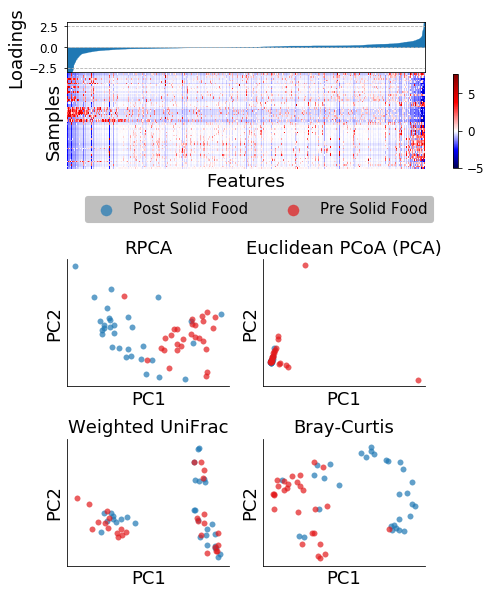

In [44]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker

plt.style.use('seaborn-paper')

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


fig = plt.figure(figsize=(7, 10), facecolor='white')
gs = gridspec.GridSpec(85, 60)
ax_map = plt.subplot(gs[8:23, :55])
ax_bar = plt.subplot(gs[0:8, :55])
ax_cbar = plt.subplot(gs[8:23, 55:])

ax_raw_complete = plt.subplot(gs[37:57, :25])
ax_raw_bray = plt.subplot(gs[37:57, 30:55])
ax_raw_uni = plt.subplot(gs[65:85, :25])
ax_raw_uni_un = plt.subplot(gs[65:85, 30:55])

ind = np.arange(feature_loading.shape[0])
ax_bar.stackplot(ind, feature_loading[0],color='#1f78b4',alpha=1)
ax_bar.set_xlim([0, feature_loading.shape[0]])
ax_bar.set_ylim([feature_loading[0].min(), feature_loading[0].max()])
ax_bar.set_xticks([])

ax_bar.set_ylim([-3, 3])
ax_bar.grid(which='major', axis='both', linestyle='--')
ax_bar.set_ylabel('Loadings', fontsize=18)
ax_bar.tick_params(labelsize=12)

sorted_df = otutabledf.reindex(index=life_stage.index, columns=feature_loading.index)
sorted_df = sorted_df.loc[:, sorted_df.sum(axis=0) > 10] #make clusters more evident 
img = ax_map.imshow(clr(centralize(sorted_df+1)), aspect='auto', 
                    norm=MidpointNormalize(midpoint=0.),
                    interpolation='nearest', cmap='seismic')

ax_map.set_xticks([])
ax_map.set_yticks([])
ax_map.set_xlabel('Features', fontsize=18)
ax_map.set_ylabel('Samples', fontsize=18)
ax_map.spines['right'].set_visible(False)
ax_map.spines['top'].set_visible(False)
ax_map.spines['bottom'].set_visible(False)
ax_map.spines['left'].set_visible(False)
ax_map.grid()

cbar = fig.colorbar(img, ax=ax_cbar) 
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
ax_cbar.grid()
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])
ax_cbar.axis('off')
ax_cbar.grid()
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])

# get pcoa for unifrac
unifrac_weighted_pcoa=pcoa(unifrac_weighted_dist).samples
unifrac_weighted_pcoa.index=list(mappingdf.index)

ax_raw_complete = plot_lifestage(sample_loading, mappingdf, ax_raw_complete)
ax_raw_bray = plot_lifestage(raw_res.samples, mappingdf, ax_raw_bray)
ax_raw_uni = plot_lifestage(unifrac_weighted_pcoa, mappingdf, ax_raw_uni)
ax_raw_uni_un = plot_lifestage(bray_pcoa.samples, mappingdf, ax_raw_uni_un)
ax_raw_uni.set_title('Weighted UniFrac', fontsize=18)
ax_raw_uni_un.set_title('Bray-Curtis', fontsize=18)
ax_raw_complete.set_title('RPCA', fontsize=18)
ax_raw_bray.set_title('Euclidean PCoA (PCA)', fontsize=18)

ax_raw_uni_un.legend(loc=1,bbox_to_anchor=(1.1, 2.97),prop={'size':15},
                     fancybox=True, framealpha=0.5,ncol=2
                     , markerscale=2, facecolor="grey")

fig.savefig('figures/figure3B.png',dpi=300, bbox_inches='tight',facecolor='white')
plt.show()


#### plot the taxonomy seperated by the feature weights


In [40]:
cutoff_=2
features=get_enriched_labels(feature_loading.copy(),cutoff=cutoff_)
mean_abundances=get_mean_abundance(otutabledf,mappingdf,features,'solidfood')
index_level_tax=get_lowest_level(taxonomy,features,default_highest=-3)

#group by lowest level
mean_abundances.index=[index_level_tax[i] for i in mean_abundances.index]
mean_abundances=mean_abundances.groupby(mean_abundances.index).sum()

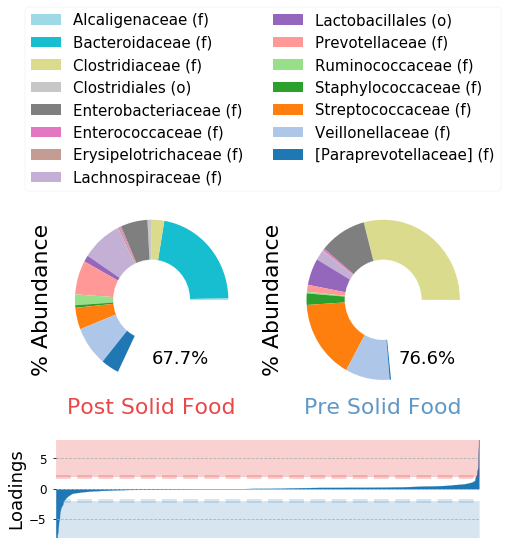

In [42]:

fig = plt.figure(figsize=(8, 10), facecolor='white')
gs = gridspec.GridSpec(16, 58)

ax_legend = plt.subplot(gs[0:4, :55])
ax_bar = plt.subplot(gs[12:15, :55])
ax_group1 = plt.subplot(gs[5:11, :25])
ax_group2 = plt.subplot(gs[5:11, 30:55])

ind = np.arange(feature_loading.shape[0])
ax_bar.stackplot(ind, feature_loading[0],color='#1f78b4',alpha=1)
ax_bar.set_xlim([0, feature_loading.shape[0]])
ax_bar.set_ylim([feature_loading[0].min(), feature_loading[0].max()])
ax_bar.set_xticks([])
ax_bar.axhline(cutoff_,lw=4,ls='--',color="#e41a1c",alpha=.2)
ax_bar.axhline(-cutoff_,lw=4,ls='--',color="#377eb8",alpha=.2)
ax_bar.fill_between(ind, cutoff_,feature_loading[0].max(), color="#e41a1c",alpha=.2)  
ax_bar.fill_between(ind, -cutoff_,feature_loading[0].min(), color="#377eb8",alpha=.2)  
ax_bar.set_ylim([-8, 8])
ax_bar.grid(which='major', axis='both', linestyle='--')
ax_bar.set_ylabel('Loadings', fontsize=18)
ax_bar.tick_params(labelsize=12)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.spines['left'].set_visible(False)

locs=[(.0,-.8),(.2,-.8)]
percs=[str(x)[:4]+'%' for x in list(mean_abundances.sum())]
for (count_,group_),ax,cols_ in zip(enumerate(mean_abundances.columns),
                             [ax_group1,ax_group2]
                                   ,['#e41a1c','#377eb8']):
    all_pie=mean_abundances.copy()
    
    all_pie[group_]=all_pie[group_]/100
    
    # Create a circle for the center of the plot
    my_circle=plt.Circle( (0,0), 0.5, color='white')

    all_pie[group_].T.plot.pie(ax=ax,
                                    labels=['' for x in mean_abundances[group_].values],
                                   colormap='tab20_r')

    ax.set_ylabel('% Abundance',fontsize=22)
    ax.add_artist(my_circle)
    ax.annotate(percs[count_], locs[count_],fontsize=18)
    ax.set_title(group_,fontsize=22,y=-.10,color=cols_,alpha=.8)
    
ax_group1.legend(labels=all_pie.index,title=""
                 , loc=2,prop={'size':15}
                 ,bbox_to_anchor=(-0.2, 2),
                ncol=math.floor(np.sqrt(len(mean_abundances.index)))-1) 

ax_legend.grid()
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.axis('off')
ax_legend.grid()
ax_legend.set_xticks([])
ax_legend.set_yticks([])
fig.savefig('figures/figure4B.png',dpi=300, bbox_inches='tight',facecolor='white')
plt.show()